In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

from sqlalchemy import create_engine
from tqdm import tqdm
from rdsutils.aws import download_s3 #, python_object_to_s3

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_feather('../data/labeled/labeled_1597354481.feather')

In [3]:
v1_features = ['transaction_amount', 'fico_score', 'vantage_score',
            'fraud_score_1', 'fraud_score_2', 'email_risk_score', 'phone_risk_score',  'all8220', 
            'iqt9415', 'all7120', 'mtf5820', 'bcc7120', 'bcc2800', 'iln5520', 'bcx3423', 'stu5031',
            'nr_direct_deposits', 'nr_past_returns', 'rolling_trns_as_pct_of_bal', 
            'nr_transactions_per_day', 'transaction_as_pct_of_balance', 
            'transaction_as_pct_of_bal_min', 'rolling_mean_acc_bal', 
              'real_ending_balance', # old 'account_ending_balance'
              'days_since_first_deposit' # old 'days_since_first_transaction'
              ]

features = ['transaction_amount', 'real_ending_balance', 'fico_score', 
            'vantage_score', 'all7120', 'all8220', 'bcc2800', 'bcc7120', 
            'bcx3423', 'iln5520', 'iqt9413', 'iqt9415', 'mtf5820', 'stu5031', 
            'credit_card_loan_amount', 'delinquencies_90_days', 'education_loan_amount',
            'mortgage_loan_amount', 'secured_loan_amount', 'total_outstanding_balance', 
            'total_tradelines_open', 'unsecured_loan_amount', 'giact_is_pass', 
            'giact_is_decline', 'giact_is_other', 'giact_nr_pass', 'giact_nr_decline',
            'giact_nr_other', 'fraud_score_1', 'fraud_score_2', 'address_risk_score', 
            'email_risk_score', 'phone_risk_score', 'name_address_correlation', 
            'name_email_correlation', 'name_phone_correlation', 'nr_social_profiles_found', 
            'days_since_first_deposit', 'lag_acc_open_first_transaction', 'first_deposit_amount', 
            'giact_time_since_first_link', 'giact_time_since_last_link', 'transaction_as_pct_of_balance', 
            'time_since_last_transaction', 'nr_past_returns', 'nr_returns_30d', 'nr_past_deposits',
            'nr_deposits_3d', 'nr_deposits_30d', 'nr_past_transactions', 'nr_transactions_3d',
            'nr_transactions_30d', 'pct_returned_deposits', 'pct_returned_deposits_30d',
            'nr_transactions_30d_div_nr_past_transactions', 'mean_account_balance_3d',
            'mean_account_balance_30d', 'std_account_balance_3d', 'std_account_balance_30d', 
            'sum_deposits_3d', 'sum_deposits_10d', 'sum_deposits_30d', 'sum_withdrawals_3d', 
            'sum_withdrawals_10d', 'sum_withdrawals_30d', 'mean_deposits_10d', 
            'mean_deposits', 'mean_deposits_10d_div_mean_deposits', 'mean_withdrawals_10d', 
            'mean_withdrawals', 'mean_withdrawals_10d_div_mean_withdrawals', 'max_deposits_3d', 
            'max_deposits_10d', 'max_deposits_10d_div_mean_deposits',
            'max_deposits_10d_div_mean_account_balance_30d', 'max_withdrawals', 
            'max_withdrawals_3d', 'max_withdrawals_10d', 'max_withdrawals_10d_div_mean_withdrawals',
            'nr_trans_ratio', 'bal_ratio', 'deposits_ratio', 'nr_direct_deposits', 'dollar_val_dd'] + v1_features
features = sorted(list(set(features)))

<AxesSubplot:>

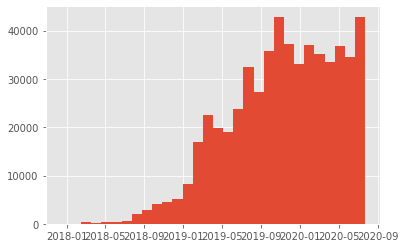

In [4]:
df.transaction_datetime.hist(bins=30)

In [5]:
modeling_df = df[df["transaction_datetime"].between(pd.to_datetime('2019-01-16'),
                                                    pd.to_datetime('2020-02-14'))]
test_df1 = df[df["transaction_datetime"].between(pd.to_datetime('2020-03-01'),
                                                 pd.to_datetime('2020-04-01'))]
test_df2 = df[df["transaction_datetime"].between(pd.to_datetime('2020-04-01'),
                                                 pd.to_datetime('2020-05-01'))]

<AxesSubplot:>

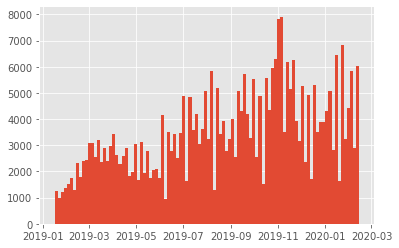

In [6]:
modeling_df.transaction_datetime.hist(bins=100)

In [7]:
modeling_df[['target', 'indeterminate']].value_counts()

target  indeterminate
False   False            336115
True    False              5896
        True               4190
False   True               3412
dtype: int64

In [8]:
modeling_df = modeling_df[~modeling_df.indeterminate]

In [9]:
modeling_df.target.value_counts()

False    336115
True       5896
Name: target, dtype: int64

In [10]:
count_pos = modeling_df['target'].sum()
count_neg = (~modeling_df['target']).sum()
pos_wgt_scaling_factor = count_neg / count_pos

### Boruta
---

In [48]:
import lightgbm as lgb
from rdsutils.boruta import Boruta

In [49]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', metric='auc', max_depth=4, 
                         n_estimators=250, colsample_bytree=0.6, 
                         learning_rate=0.1, reg_alpha=10, scale_pos_weight=pos_wgt_scaling_factor, 
                         min_data_in_leaf=50, random_state=222)
fsel = Boruta(clf, drop_at=-15, max_iter=50, random_state=10, thresh=0.3, verbose=1) 

In [52]:
%time fsel.fit(modeling_df[features].values, modeling_df['target'].values) 

CPU times: user 58min 52s, sys: 30.6 s, total: 59min 23s
Wall time: 10min 42s


In [53]:
dimp = pd.DataFrame({'feature': features, 
                     'score': fsel.scores, 
                     'mean_imp': np.mean(fsel.imps, axis=0)})\
                    .sort_values(by=['score', 'mean_imp'], 
                                 ascending=False)

In [54]:
display(dimp)

,feature,score,mean_imp
87,vantage_score,50.0,141.02
15,first_deposit_amount,50.0,103.04
14,fico_score,50.0,92.76
16,fraud_score_1,50.0,78.68
7,credit_card_loan_amount,48.0,73.52
...,...,...,...
18,giact_is_decline,-15.0,0.48
11,dollar_val_dd,-15.0,0.40
9,delinquencies_90_days,-15.0,0.30
57,nr_returns_30d,-15.0,0.20


In [55]:
import time
timestamp_str = str(int(time.time()))

dimp.to_csv('../artifacts/fsel_result_{}.csv'.format(timestamp_str), index=False)

### VIF
---

In [125]:
from scipy.stats import iqr

In [130]:
import sys
# sys.path = ['/home/ec2-user/SageMaker/rdsutils'] + sys.path

In [135]:
# from rdsutils.feature_selection import calculate_vif_, get_feature_info_unsup

import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor    


def get_feature_info_unsup(series):
    """Get feature info (unsupervised).
    
    Parameters
    ----------
    series : pd.Series
        feature column
    fns : dict
        Dictionary of functions to apply

    Returns
    -------
    stats : some stats
    """
    stats = {}
    if pd.api.types.is_numeric_dtype(series):
        stats["mean"] = series.mean()
        stats["std"] = series.std()
        stats["variance"] = series.var()
        stats["min"] = series.min()
        stats["max"] = series.max()
        stats["iqr"] = iqr(series)
        stats["kurtosis"] = series.kurt()
        stats["skewness"] = series.skew()
        stats["sum"] = series.sum()
        stats["mad"] = series.mad()
        stats["n_zeros"] = (len(series) - np.count_nonzero(series))
        stats["p_zeros"] = round(100 * float(stats["n_zeros"]) / len(series), 2)
        stats["cv"] = stats["std"] / stats["mean"] if stats["mean"] else np.NaN

    stats["n_unique"] = len(series.unique())
    stats["p_unique"] = round(100 * float(stats["n_unique"] / len(series)), 2)
    
    stats["n_missing"] = series.isna().sum()
    stats["p_missing"] = round(100 * float(stats["n_missing"] / len(series)), 2)
            
    return stats


def calculate_vif_(X):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [137]:
desc = get_feature_info_unsup(modeling_df['fico_score'])
desc

{'mean': 906.5820778227015,
 'std': 1180.6147750979953,
 'variance': 1393851.24717969,
 'min': 388.0,
 'max': 9003.0,
 'iqr': nan,
 'kurtosis': 42.880066673296135,
 'skewness': 6.685440899628925,
 'sum': 263018499.0,
 'mad': 335.92939824132105,
 'n_zeros': 0,
 'p_zeros': 0.0,
 'cv': 1.3022701462766904,
 'n_unique': 437,
 'p_unique': 0.13,
 'n_missing': 51890,
 'p_missing': 15.17}

In [142]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

vif(modeling_df.fico_score.values, 0)

IndexError: tuple index out of range

### WOE and IV
---

In [11]:
from rdsutils import woe

In [12]:
feature_df = modeling_df[features]
feature_df['target_num'] = modeling_df['target'].astype(int)
is_numeric_col = [np.issubdtype(d, np.number) for d in feature_df.dtypes]
num_feature_df = feature_df.iloc[:, is_numeric_col].head()

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [13]:
feature_df['target_num'].value_counts()

0    336115
1      5896
Name: target_num, dtype: int64

In [18]:
feature_df['target_num'].value_counts()

0    336115
1      5896
Name: target_num, dtype: int64

In [14]:
woe_eq=woe.WOE_Transform(method='equal', num_bin_start=10, min_iv=0.02, min_samples_leaf=100)
woe_eq.fit(feature_df[features], feature_df['target_num'], display=25)

giact_is_decline -iv:  0.4157 
               attr      value    #accts  %accts     #good    #bad dist_good  \
0  giact_is_decline      False  270578.0  79.11%  266183.0  4395.0    79.19%   
1  giact_is_decline       True    6723.0   1.97%    5749.0   974.0     1.71%   
2  giact_is_decline  1:Missing   64710.0  18.92%   64183.0   527.0    19.10%   

  dist_bad target_rate       woe      iv  
0   74.54%       1.62% -0.060537  0.0028  
1   16.52%      14.49%  2.267809  0.3358  
2    8.94%       0.81% -0.759114  0.0771  

giact_is_other -iv:  0.5887 
             attr      value    #accts  %accts     #good    #bad dist_good  \
0  giact_is_other      False  246654.0  72.12%  243539.0  3115.0    72.46%   
1  giact_is_other       True   30647.0   8.96%   28393.0  2254.0     8.45%   
2  giact_is_other  1:Missing   64710.0  18.92%   64183.0   527.0    19.10%   

  dist_bad target_rate       woe      iv  
0   52.83%       1.26% -0.315869  0.0620  
1   38.23%       7.35%  1.509743  0.4496  
2   

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


bcc2800 -iv:  1.709 
            attr  min   max    #accts  %accts     #good    #bad dist_good  \
0        bcc2800  0.0   1.0  268548.0  78.52%  266474.0  2074.0    79.28%   
1        bcc2800  2.0  99.0   21573.0   6.31%   18119.0  3454.0     5.39%   
missing  bcc2800  NaN   NaN   51890.0  15.17%   51522.0   368.0    15.33%   

        dist_bad target_rate     woe      iv  
0         35.18%       0.77% -0.8126  0.3584  
1         58.58%      16.01%  2.3858  1.2690  
missing    6.24%       0.71% -0.8985  0.0816  

bcc7120 -iv:  2.7955 
            attr    min    max    #accts  %accts     #good    #bad dist_good  \
0        bcc7120    0.0   20.0  117128.0  34.25%  116777.0   351.0    34.74%   
1        bcc7120   21.0   82.0   87317.0  25.53%   87039.0   278.0    25.90%   
2        bcc7120   83.0   96.0   30963.0   9.05%   30813.0   150.0     9.17%   
3        bcc7120   97.0  102.0   28522.0   8.34%   28279.0   243.0     8.41%   
4        bcc7120  103.0  999.0   26191.0   7.66%   21685.0 

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/pandas/core/algorithms.py:1056: RuntimeWarning: invalid value encountered in double_scalars
  return a + (b - a) * fraction


processed  85  num attributes



                       attr     min    max   #accts  %accts    #bad  \
0        address_risk_score  0.0000  0.093  64524.0  18.87%   333.0   
1        address_risk_score  0.0934  0.183  32412.0   9.48%   181.0   
2        address_risk_score  0.1840  0.279  32252.0   9.43%   315.0   
3        address_risk_score  0.2794  0.374  32383.0   9.47%   390.0   
4        address_risk_score  0.3750  0.477  32367.0   9.46%   502.0   
5        address_risk_score  0.4777  0.582  31993.0   9.35%   668.0   
6        address_risk_score  0.5830  0.727  32622.0   9.54%   990.0   
7        address_risk_score  0.7280  1.000  63987.0  18.71%  2122.0   
missing  address_risk_score     NaN    NaN  19471.0   5.69%   395.0   

        target_rate  
0             0.52%  
1             0.56%  
2             0.98%  
3             1.20%  
4             1.55%  
5             2.09%  
6             3.03%  
7             3.32%  
missing       2.03%  

            attr    min    max    #accts  %accts    #bad target_rate

In [187]:
iv_table = woe_eq.get_iv().sort_values(by=['iv'], ascending=False)

In [188]:
iv_table.head(20)

,attr,iv
87,vantage_score,3.0408
8,bcc7120,2.7955
10,credit_card_loan_amount,2.6780
82,total_tradelines_open,2.2872
81,total_outstanding_balance,2.0444
9,bcx3423,2.0031
4,all7120,1.7926
11,days_since_first_deposit,1.7278
7,bcc2800,1.7090
25,giact_time_since_last_link,1.4061


### Correlation
---

In [204]:
boruta_features = pd.read_csv('../artifacts/fsel_result_1598212148.csv')
boruta_features = boruta_features[boruta_features.score > 0].feature.values
fs = FeatureSelector(data=feature_df[boruta_features], labels=feature_df.target_num)

In [205]:
fs.identify_missing(missing_threshold=0.3)

0 features with greater than 0.30 missing values.



In [206]:
missing_features = fs.ops['missing']
missing_features

[]

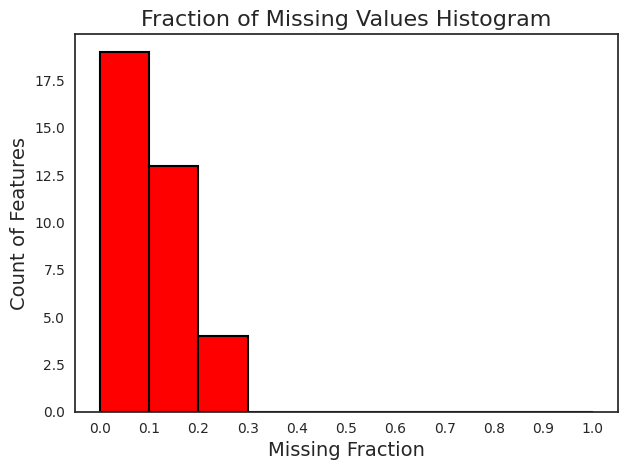

In [207]:
fs.plot_missing()

In [208]:
%time fs.identify_collinear(correlation_threshold=0.6)

9 features with a correlation magnitude greater than 0.60.

CPU times: user 1.21 s, sys: 20 ms, total: 1.23 s
Wall time: 1.23 s


In [209]:
correlated_features = fs.ops['collinear']
correlated_features[:5]

['sum_withdrawals_10d',
 'sum_withdrawals_3d',
 'all7120',
 'all8220',
 'days_since_first_deposit']

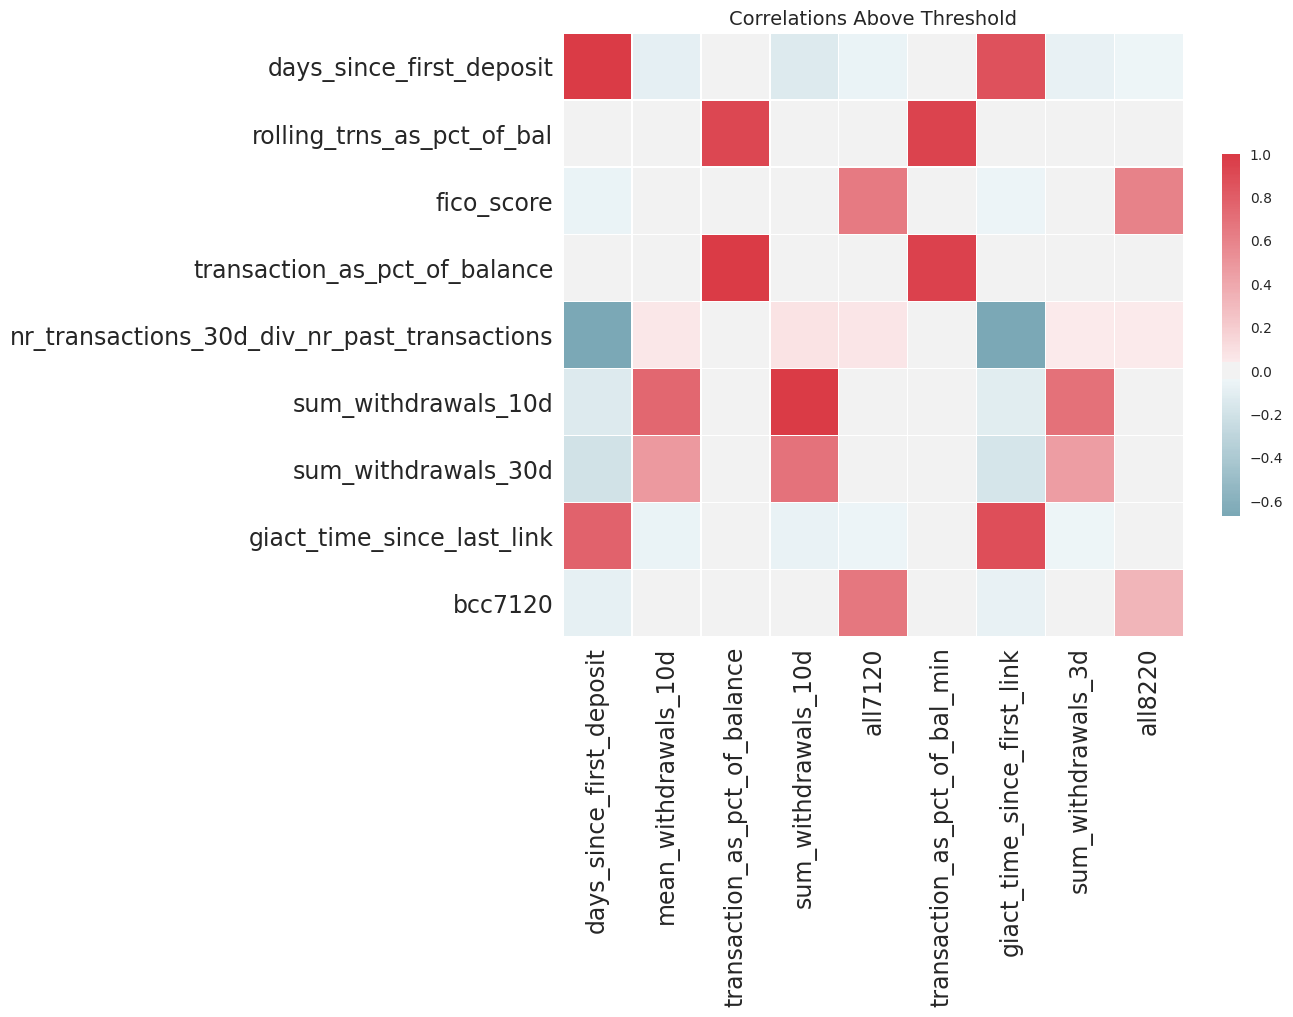

In [212]:
fs.plot_collinear()